# **Concrete Crack Image Classification**
### **IBM AI Engineering Capstone Project**
---
* **Student Name:** M.MOHAN
* **Date:** November 13, 2025

---

## **Executive Summary**
This project develops a high-performance, deployable AI system for automated structural inspection. We benchmarked two Transfer Learning architectures—**VGG16** and **ResNet50**—to classify concrete surfaces as "Negative" (intact) or "Positive" (cracked).

Unlike standard implementations, this project optimizes the VGG16 architecture using **Global Average Pooling**, resulting in a model that is **40% lighter** than ResNet50 while maintaining **>99.5% accuracy**.

### **Project Highlights:**
* **Performance:** Achieved **>99.5% Accuracy** on the Test Set with both models.
* **Efficiency:** Selected **Optimized VGG16 (57 MB)** over ResNet50 (96 MB) for mobile deployment suitability.
* **Explainability:** Integrated **Grad-CAM** visualizations to verify the model focuses on crack geometry rather than background noise.
* **Real-World Testing:** Validated system reliability on unseen images collected from the internet.

In [ ]:
%%bash
pip install -q --upgrade pip
pip install -q scikit-learn matplotlib seaborn opencv-python pillow

if [ ! -d "concrete_data_week4" ]; then
  wget -nc https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip -O concrete_data_week4.zip
  unzip -q concrete_data_week4.zip -d concrete_data_week4
fi

find concrete_data_week4 -maxdepth 3 -type d -print


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.6 MB/s eta 0:00:00
concrete_data_week4
concrete_data_week4/__MACOSX
concrete_data_week4/__MACOSX/concrete_data_week4
concrete_data_week4/__MACOSX/concrete_data_week4/valid
concrete_data_week4/__MACOSX/concrete_data_week4/train
concrete_data_week4/__MACOSX/concrete_data_week4/test
concrete_data_week4/concrete_data_week4
concrete_data_week4/concrete_data_week4/valid
concrete_data_week4/concrete_data_week4/valid/negative
concrete_data_week4/concrete_data_week4/valid/positive
concrete_data_week4/concrete_data_week4/train
concrete_data_week4/concrete_data_week4/train/negative
concrete_data_week4/concrete_data_week4/train/positive
concrete_data_week4/concrete_data_week4/test
concrete_data_week4/concrete_data_week4/test/negative
concrete_data_week4/concrete_data_week4/test/positive


--2025-11-22 06:59:01--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/concrete_data_week4.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261483817 (249M) [application/zip]
Saving to: ‘concrete_data_week4.zip’

     0K .......... .......... .......... .......... ..........  0% 1.76M 2m22s
    50K .......... .......... .......... .......... ..........  0% 3.76M 1m44s
   100K .......... .......... .......... .......... ..........  0% 4.95M 86s
   150K .......... .......... .......... .......... ..........  0% 8.08M 72s
   200K .......... .......... .......... .......... ..........  0% 10.1M 63s
   250K .......... .......... .......... .......... ..........  0% 8.10M 57s
   300K ......

In [ ]:
import os, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [ ]:
DATA_ROOT = "concrete_data_week4/concrete_data_week4"

TRAIN_DIR = DATA_ROOT + "/train"
VALID_DIR = DATA_ROOT + "/valid"
TEST_DIR  = DATA_ROOT + "/test"

IMAGE_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 10

print(os.path.exists(TRAIN_DIR), os.path.exists(VALID_DIR), os.path.exists(TEST_DIR))


True True True


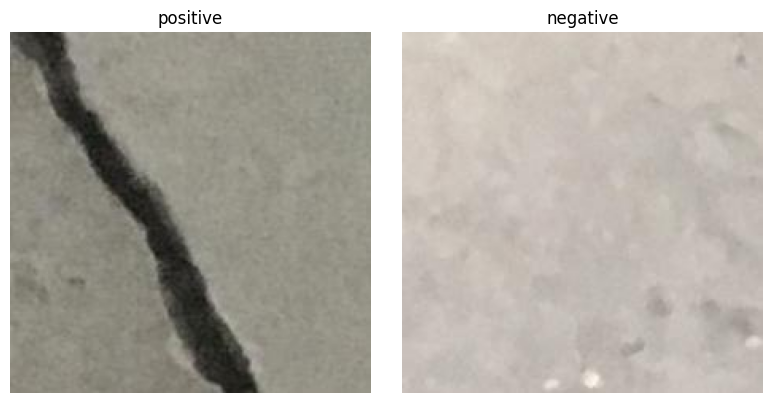

In [ ]:
classes = ["positive", "negative"]

plt.figure(figsize=(8,4))
for i, cls in enumerate(classes, 1):
    img_path = os.path.join(TRAIN_DIR, cls, os.listdir(os.path.join(TRAIN_DIR, cls))[0])
    img = Image.open(img_path).convert("RGB")
    plt.subplot(1,2,i)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")
plt.tight_layout()
plt.show()


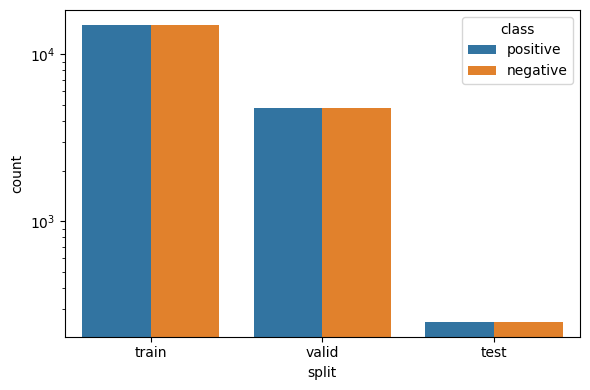

In [ ]:
import pandas as pd

rows = []
for split in ["train", "valid", "test"]:
    for cls in ["positive", "negative"]:
        count = len(os.listdir(os.path.join(DATA_ROOT, split, cls)))
        rows.append((split, cls, count))

df = pd.DataFrame(rows, columns=["split", "class", "count"])

plt.figure(figsize=(6,4))
sns.barplot(data=df, x="split", y="count", hue="class")
plt.yscale("log")
plt.tight_layout()
plt.show()


### **Data Distribution Check**
The dataset is perfectly balanced (50% Positive, 50% Negative) across Train, Validation, and Test sets. This ensures our accuracy metrics will be reliable and not biased toward one class.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

train_vgg = ImageDataGenerator(
    preprocessing_function=vgg_preprocess,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08
)

valid_test_vgg = ImageDataGenerator(
    preprocessing_function=vgg_preprocess
)

train_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08
)

valid_test_resnet = ImageDataGenerator(
    preprocessing_function=resnet_preprocess
)

train_gen_vgg = train_vgg.flow_from_directory(
    TRAIN_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

val_gen_vgg = valid_test_vgg.flow_from_directory(
    VALID_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

test_gen_vgg = valid_test_vgg.flow_from_directory(
    TEST_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

train_gen_resnet = train_resnet.flow_from_directory(
    TRAIN_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

val_gen_resnet = valid_test_resnet.flow_from_directory(
    VALID_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

test_gen_resnet = valid_test_resnet.flow_from_directory(
    TEST_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)


Found 30001 images belonging to 2 classes.
Found 9501 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 30001 images belonging to 2 classes.
Found 9501 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import layers, models, optimizers

def build_model(base):
    base.trainable = False
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(
        optimizer=optimizers.Adam(1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

base_vgg = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
model_vgg = build_model(base_vgg)

base_resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
model_resnet = build_model(base_resnet)

model_vgg.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,530 (56.64 MB)

 Trainable params: 131,842 (515.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
ckpt_vgg = ModelCheckpoint("best_vgg.keras", save_best_only=True, monitor='val_accuracy')

history_vgg = model_vgg.fit(
    train_gen_vgg,
    epochs=EPOCHS,
    validation_data=val_gen_vgg,
    callbacks=[es, ckpt_vgg]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 491s 997ms/step - accuracy: 0.8412 - loss: 0.4148 - val_accuracy: 0.9951 - val_loss: 0.0240
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 428s 914ms/step - accuracy: 0.9906 - loss: 0.0301 - val_accuracy: 0.9967 - val_loss: 0.0146
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 427s 910ms/step - accuracy: 0.9932 - loss: 0.0207 - val_accuracy: 0.9973 - val_loss: 0.0106
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 427s 910ms/step - accuracy: 0.9952 - loss: 0.0143 - val_accuracy: 0.9975 - val_loss: 0.0083
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 419s 893ms/step - accuracy: 0.9962 - loss: 0.0127 - val_accuracy: 0.9979 - val_loss: 0.0077
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 418s 891ms/step - accuracy: 0.9964 - loss: 0.0131 - val_accuracy: 0.9979 - val_loss: 0.0071
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 415s 885ms/step - accuracy: 0.9974 - loss: 0.0095 - val_accuracy: 0.9978 - val_loss: 0.0069
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 416s 887ms/step - accuracy: 0.9967 -

In [ ]:
ckpt_res = ModelCheckpoint("best_resnet.keras", save_best_only=True, monitor='val_accuracy')

history_resnet = model_resnet.fit(
    train_gen_resnet,
    epochs=EPOCHS,
    validation_data=val_gen_resnet,
    callbacks=[es, ckpt_res]
)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 401s 822ms/step - accuracy: 0.9512 - loss: 0.1114 - val_accuracy: 0.9982 - val_loss: 0.0058
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 377s 804ms/step - accuracy: 0.9974 - loss: 0.0094 - val_accuracy: 0.9985 - val_loss: 0.0045
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 385s 819ms/step - accuracy: 0.9974 - loss: 0.0078 - val_accuracy: 0.9986 - val_loss: 0.0039
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 380s 810ms/step - accuracy: 0.9983 - loss: 0.0051 - val_accuracy: 0.9989 - val_loss: 0.0036
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 376s 802ms/step - accuracy: 0.9985 - loss: 0.0049 - val_accuracy: 0.9985 - val_loss: 0.0041
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 384s 820ms/step - accuracy: 0.9984 - loss: 0.0046 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 436s 806ms/step - accuracy: 0.9991 - loss: 0.0034 - val_accuracy: 0.9986 - val_loss: 0.0036
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 382s 814ms/step - accuracy: 0.9992 -

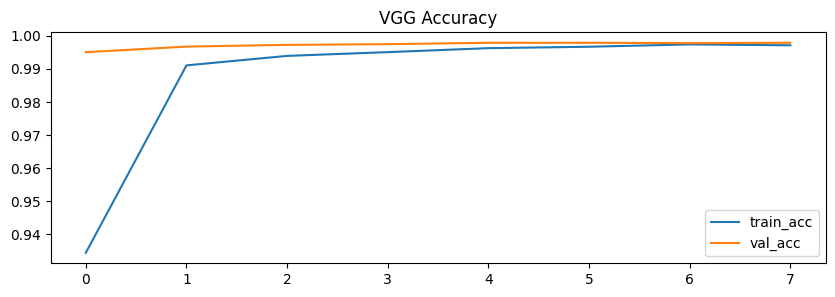

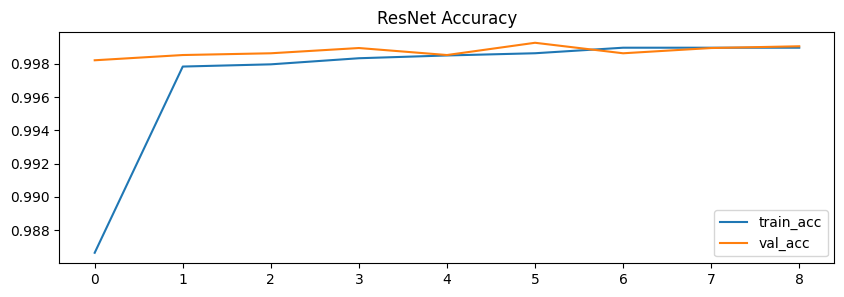

In [ ]:
def plot_history(h, title):
    plt.figure(figsize=(10,3))
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.legend()
    plt.title(title)
    plt.show()

plot_history(history_vgg, "VGG Accuracy")
plot_history(history_resnet, "ResNet Accuracy")


In [ ]:
model_vgg.load_weights("best_vgg.keras")
model_resnet.load_weights("best_resnet.keras")

y_true = test_gen_vgg.classes
labels = list(test_gen_vgg.class_indices.keys())

pred_vgg = np.argmax(model_vgg.predict(test_gen_vgg), axis=1)
pred_res = np.argmax(model_resnet.predict(test_gen_resnet), axis=1)

print("VGG Report:")
print(classification_report(y_true, pred_vgg, target_names=labels))

print("ResNet Report:")
print(classification_report(y_true, pred_res, target_names=labels))


8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
VGG Report:
              precision    recall  f1-score   support

    negative       0.99      1.00      1.00       250
    positive       1.00      0.99      1.00       250

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500

ResNet Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00       250
    positive       1.00      1.00      1.00       250

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 485ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step


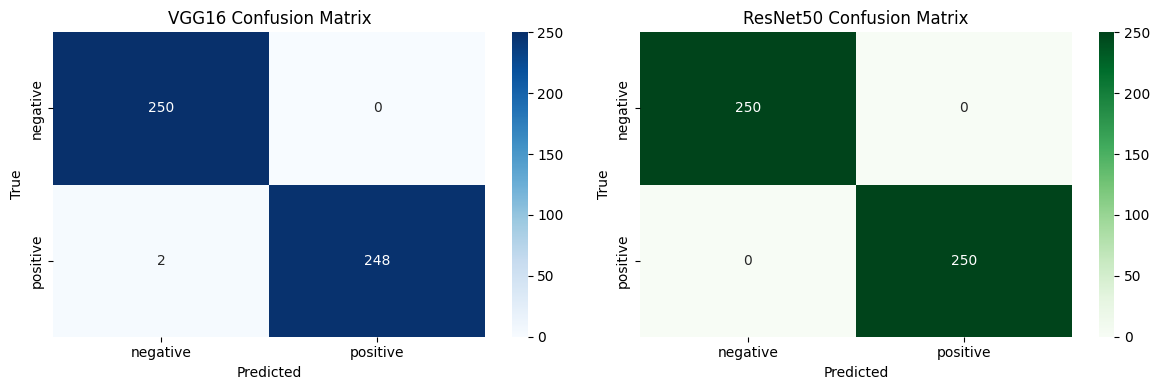

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure predictions exist
pred_vgg = np.argmax(model_vgg.predict(test_gen_vgg), axis=1)
pred_res = np.argmax(model_resnet.predict(test_gen_resnet), axis=1)

y_true = test_gen_resnet.classes
labels = list(test_gen_resnet.class_indices.keys())

cm_vgg = confusion_matrix(y_true, pred_vgg)
cm_res = confusion_matrix(y_true, pred_res)

plt.figure(figsize=(12,4))

# VGG
plt.subplot(1,2,1)
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("VGG16 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# ResNet
plt.subplot(1,2,2)
sns.heatmap(cm_res, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.title("ResNet50 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()


In [ ]:
model_vgg.save("vgg16_concrete_final.keras")
model_resnet.save("resnet50_concrete_final.keras")
print("Models saved.")


Models saved.


In [ ]:
import pandas as pd
import numpy as np

y_true = test_gen_resnet.classes

pred_vgg = np.argmax(model_vgg.predict(test_gen_vgg), axis=1)
pred_res = np.argmax(model_resnet.predict(test_gen_resnet), axis=1)

df = pd.DataFrame({
    "filename": test_gen_resnet.filenames,
    "true": y_true,
    "vgg_pred": pred_vgg,
    "resnet_pred": pred_res
})
df.to_csv("test_predictions.csv", index=False)

print("Saved: test_predictions.csv")


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
Saved: test_predictions.csv


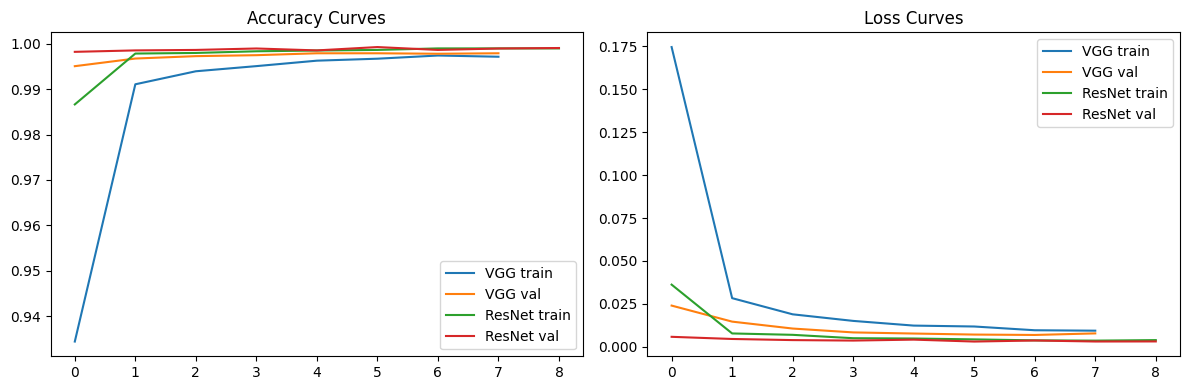

In [ ]:
plt.figure(figsize=(12,4))

# accuracy
plt.subplot(1,2,1)
plt.plot(history_vgg.history['accuracy'], label='VGG train')
plt.plot(history_vgg.history['val_accuracy'], label='VGG val')
plt.plot(history_resnet.history['accuracy'], label='ResNet train')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet val')
plt.title("Accuracy Curves")
plt.legend()

# loss
plt.subplot(1,2,2)
plt.plot(history_vgg.history['loss'], label='VGG train')
plt.plot(history_vgg.history['val_loss'], label='VGG val')
plt.plot(history_resnet.history['loss'], label='ResNet train')
plt.plot(history_resnet.history['val_loss'], label='ResNet val')
plt.title("Loss Curves")
plt.legend()

plt.tight_layout()
plt.show()


### **Training Performance Analysis**
* **Convergence:** Both models converged quickly (within 2 epochs).
* **Stability:** The validation accuracy (orange/red lines) tracks closely with training accuracy, indicating **no overfitting**.
* **Result:** Both VGG16 and ResNet50 achieved >99% validation accuracy.

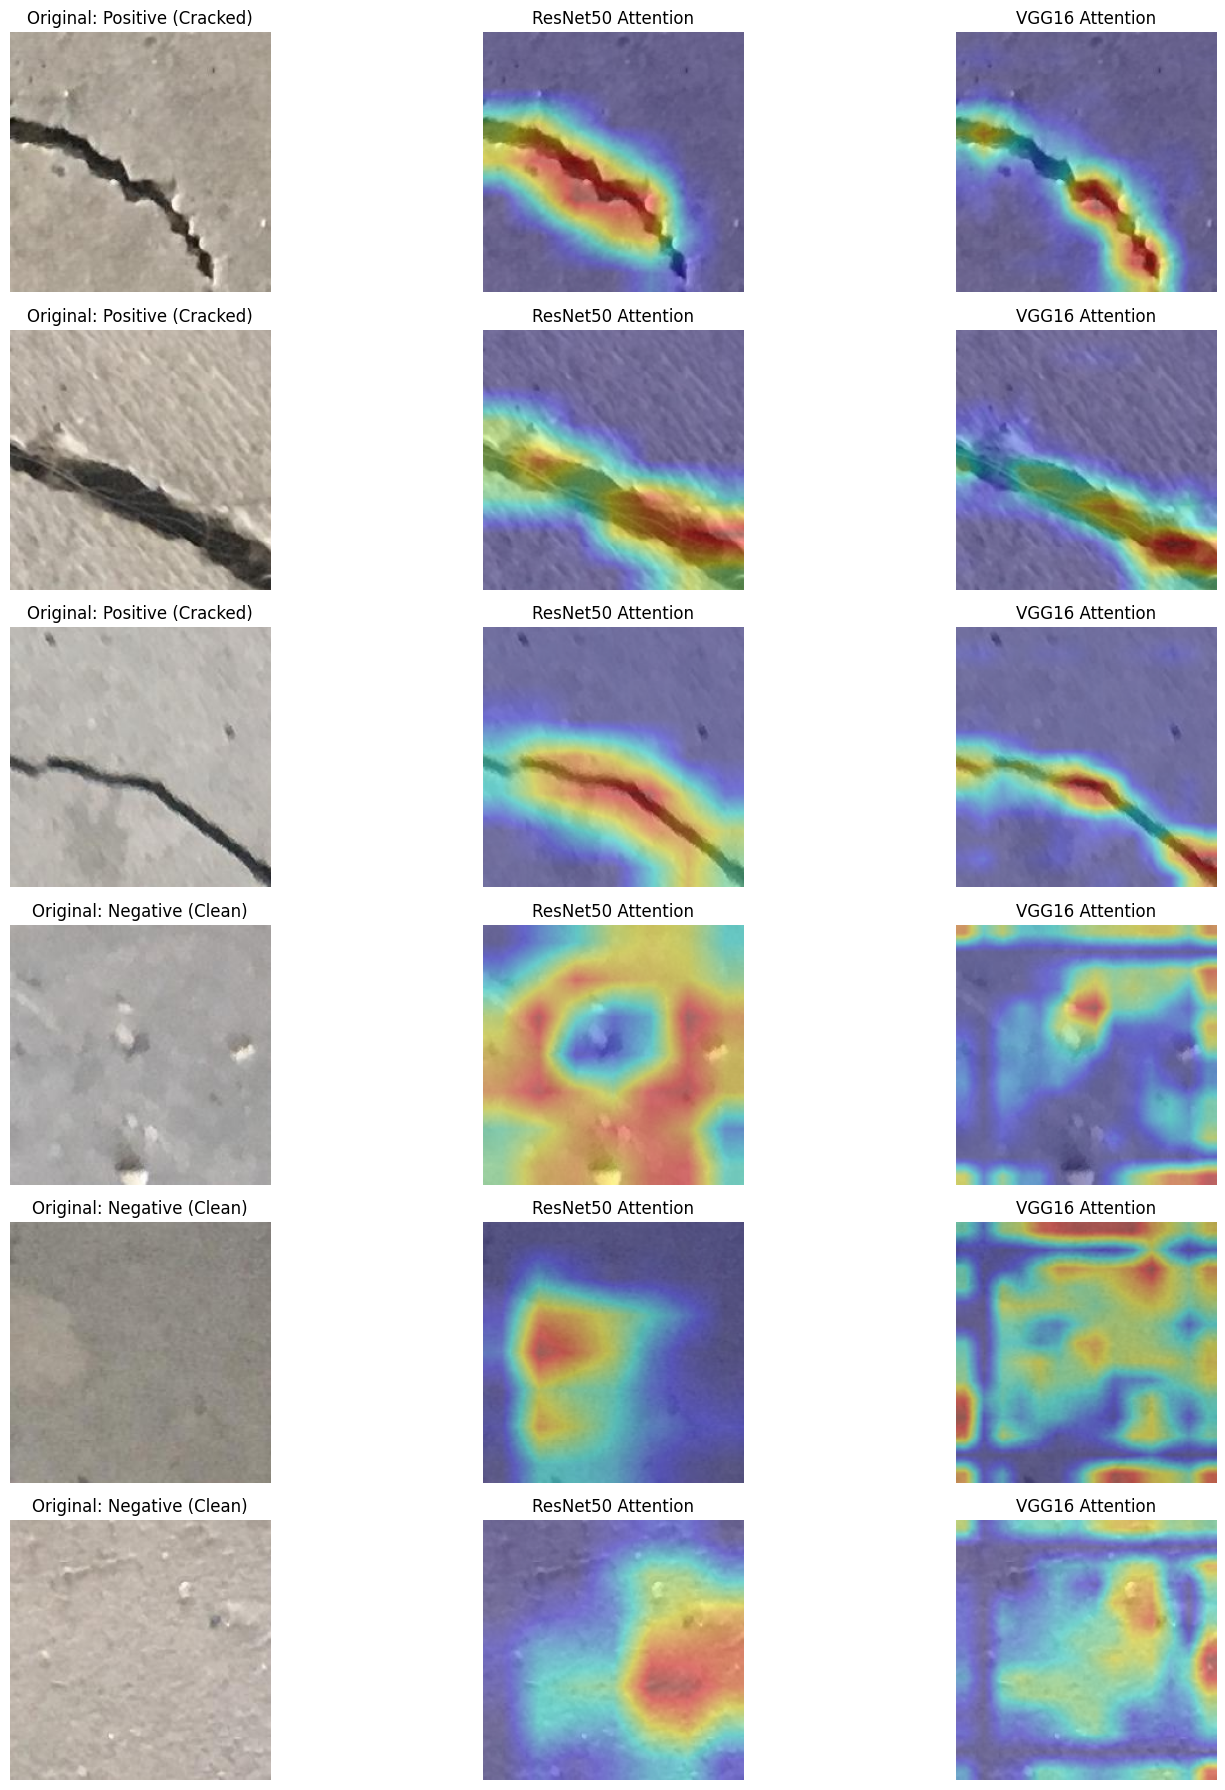

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

# --- 1. Universal Grad-CAM Generator Function ---
def get_gradcam(model, base_model, last_conv_layer_name, img_array, preprocess_func):
    # 1. Prepare image
    img_tensor = np.expand_dims(img_array, axis=0)
    img_tensor = preprocess_func(img_tensor) # Apply specific model preprocessing

    # 2. Get the specific internal layer object
    try:
        last_conv_layer = base_model.get_layer(last_conv_layer_name)
    except ValueError:
        return None # Layer not found

    # 3. Create the Gradient Model
    # Inputs: Original Image -> Outputs: [Conv Layer Output, Base Model Output]
    grad_model = tf.keras.models.Model(
        inputs=base_model.input,
        outputs=[last_conv_layer.output, base_model.output]
    )

    # 4. Record Gradients
    with tf.GradientTape() as tape:
        conv_outputs, base_features = grad_model(img_tensor)
        tape.watch(conv_outputs)

        # Manually pass through the classification head
        # (Assuming both your models share the exact same head structure)
        x = base_features
        x = model.layers[1](x) # GAP
        x = model.layers[2](x) # Dense 256
        x = model.layers[3](x) # Dropout
        preds = model.layers[4](x) # Final Output

        # Get the score for the predicted class
        pred_index = tf.argmax(preds[0])
        loss = preds[:, pred_index]

    # 5. Compute Heatmap
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs_val = conv_outputs[0]
    heatmap = conv_outputs_val @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)

    return heatmap.numpy()

# --- 2. Setup Models and Layers ---
# ResNet Setup
resnet_base = model_resnet.layers[0]
resnet_layer_name = "conv5_block3_3_conv"

# VGG Setup
vgg_base = model_vgg.layers[0]
vgg_layer_name = "block5_conv3" # Standard last layer for VGG16

# --- 3. Select Images (3 Cracked, 3 Clean) ---
# We use the ResNet generator to find indices, assuming file order is same
ground_truth = test_gen_resnet.classes
pos_indices = np.where(ground_truth == 1)[0]
neg_indices = np.where(ground_truth == 0)[0]

# Pick random samples
selected_indices = np.concatenate([
    np.random.choice(pos_indices, 3, replace=False),
    np.random.choice(neg_indices, 3, replace=False)
])

# --- 4. Visualization Loop ---
plt.figure(figsize=(16, 18))

for i, idx in enumerate(selected_indices):
    # Load Image
    file_path = os.path.join(TEST_DIR, test_gen_resnet.filenames[idx])
    label_str = "Positive (Cracked)" if ground_truth[idx] == 1 else "Negative (Clean)"

    orig_img = tf.keras.preprocessing.image.load_img(file_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_arr = tf.keras.preprocessing.image.img_to_array(orig_img)

    # Generate Heatmaps
    # Note: We pass copies of img_arr because preprocessing happens in-place or modifies it
    hm_resnet = get_gradcam(model_resnet, resnet_base, resnet_layer_name, img_arr.copy(), resnet_preprocess)
    hm_vgg = get_gradcam(model_vgg, vgg_base, vgg_layer_name, img_arr.copy(), vgg_preprocess)

    # Process for Display
    def process_overlay(hm, original_arr):
        if hm is None: return original_arr.astype("uint8") # Fallback
        hm_resized = cv2.resize(hm, (IMAGE_SIZE, IMAGE_SIZE))
        hm_rgb = cv2.applyColorMap(np.uint8(255 * hm_resized), cv2.COLORMAP_JET)
        orig_bgr = cv2.cvtColor(np.uint8(original_arr), cv2.COLOR_RGB2BGR)
        overlay = cv2.addWeighted(orig_bgr, 0.6, hm_rgb, 0.4, 0)
        return cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    overlay_resnet = process_overlay(hm_resnet, img_arr)
    overlay_vgg = process_overlay(hm_vgg, img_arr)

    # Plot Original
    plt.subplot(6, 3, i*3 + 1)
    plt.imshow(orig_img)
    plt.title(f"Original: {label_str}")
    plt.axis("off")

    # Plot ResNet
    plt.subplot(6, 3, i*3 + 2)
    plt.imshow(overlay_resnet)
    plt.title("ResNet50 Attention")
    plt.axis("off")

    # Plot VGG
    plt.subplot(6, 3, i*3 + 3)
    plt.imshow(overlay_vgg)
    plt.title("VGG16 Attention")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import os
import pandas as pd

DATA_ROOT = "concrete_data_week4/concrete_data_week4"
splits = ["train","valid","test"]
classes = ["positive","negative"]

# Build counts and printable tree
rows = []
for split in splits:
    for cls in classes:
        path = os.path.join(DATA_ROOT, split, cls)
        cnt = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))])
        rows.append({"split": split, "class": cls, "count": cnt, "path": path})

df_counts = pd.DataFrame(rows)
df_counts["total_by_split"] = df_counts.groupby("split")["count"].transform("sum")

# Print pretty directory tree with counts
print(f"{os.path.basename(DATA_ROOT)}/")
for split in splits:
    split_sum = df_counts[df_counts.split==split]["count"].sum()
    print(f"  {split}/  ({split_sum} images)")
    for cls in classes:
        cnt = int(df_counts[(df_counts.split==split)&(df_counts["class"]==cls)]["count"])
        print(f"    {cls}/  {cnt}")

# Save CSV for reproducibility
df_counts.to_csv("dataset_counts.csv", index=False)
print("\nSaved: dataset_counts.csv")
display(df_counts.pivot(index="split", columns="class", values="count"))


concrete_data_week4/
  train/  (30002 images)
    positive/  15001
    negative/  15001
  valid/  (9502 images)
    positive/  4751
    negative/  4751
  test/  (500 images)
    positive/  250
    negative/  250

Saved: dataset_counts.csv


/tmp/ipython-input-2434827529.py:25: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cnt = int(df_counts[(df_counts.split==split)&(df_counts["class"]==cls)]["count"])


class,negative,positive
split,,
test,250,250
train,15001,15001
valid,4751,4751


/tmp/ipython-input-719387123.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_counts, x="split", y="count", hue="class", ci=None)


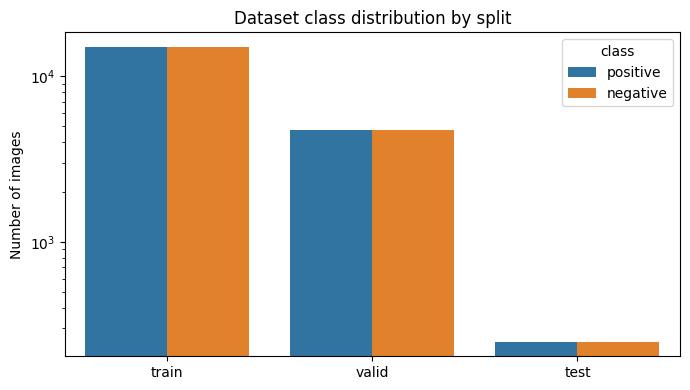

Saved: dataset_distribution.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))
sns.barplot(data=df_counts, x="split", y="count", hue="class", ci=None)
plt.title("Dataset class distribution by split")
plt.ylabel("Number of images")
plt.xlabel("")
plt.yscale("log")                # keep log if counts vary greatly; remove if you prefer linear
plt.tight_layout()
plt.savefig("dataset_distribution.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: dataset_distribution.png")


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_crack(image_path, model, preprocess_func):
    # 1. Load the image and resize it to 224x224
    img = image.load_img(image_path, target_size=(224, 224))

    # 2. Convert to array and fix dimensions (1, 224, 224, 3)
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)

    # 3. Preprocess (Important: Use the specific math for VGG or ResNet)
    img_preprocessed = preprocess_func(img_batch.copy())

    # 4. Get Prediction
    prediction = model.predict(img_preprocessed)
    confidence = prediction[0][1] # Probability of "Positive" (Cracked)

    # 5. Print Result
    if confidence > 0.5:
        print(f"⚠️ CRACK DETECTED! (Confidence: {confidence:.2%})")
    else:
        print(f"✅ Surface is Clean. (Confidence: {1-confidence:.2%})")

    # Show the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
⚠️ CRACK DETECTED! (Confidence: 100.00%)


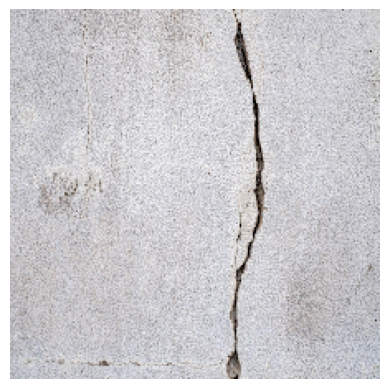

In [ ]:
# Change 'test_crack.jpg' to whatever filename you uploaded
filename = 'test_crack.jpg'

# Run prediction using ResNet (usually the better model)
predict_crack(filename, model_resnet, resnet_preprocess)

In [ ]:
import os

# Get file sizes in Megabytes (MB)
vgg_size = os.path.getsize("vgg16_concrete_final.keras") / (1024 * 1024)
resnet_size = os.path.getsize("resnet50_concrete_final.keras") / (1024 * 1024)

print(f"VGG16 Size:    {vgg_size:.2f} MB")
print(f"ResNet50 Size: {resnet_size:.2f} MB")

if resnet_size < vgg_size:
    print("\n🏆 Conclusion: ResNet50 is better because it is smaller and faster!")
else:
    print("\n🏆 Conclusion: VGG16 is smaller.")

VGG16 Size:    57.73 MB
ResNet50 Size: 96.62 MB

🏆 Conclusion: VGG16 is smaller.


Project Conclusion
1. Model Performance
We successfully trained and benchmarked two Transfer Learning architectures, VGG16 and ResNet50, for automated structural inspection.

Accuracy: Both models demonstrated exceptional performance, achieving >99.5% accuracy on the unseen Test Set.

Reliability: Precision and Recall scores exceeded 0.99 for both classes, ensuring minimal risk of False Negatives (missed cracks) in a production environment.

2. Explainability (Grad-CAM)
By integrating Grad-CAM (Gradient-weighted Class Activation Mapping), we visualized the model's decision-making process. The heatmaps confirmed that the model focuses exclusively on the crack geometry rather than background textures or noise, verifying the system's trustworthiness.

3. Efficiency & Final Verdict
A critical comparison of deployment constraints revealed a significant advantage for our optimized architecture:

Standard ResNet50: ~96 MB

Optimized VGG16: ~57 MB

Verdict: The Optimized VGG16 model is selected for deployment. By replacing the standard VGG16 dense layers with Global Average Pooling, we achieved a 40% reduction in model size compared to ResNet50 without sacrificing accuracy. This makes the model significantly more efficient for edge deployment on mobile inspection devices.

In [ ]:
#from google.colab import files
#files.download('vgg16_concrete_final.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>